# Usage of pretrained models and the library

In [ ]:
from fastai_ulmfit.pretrained import *
from fastai.text.all import *

In this example the **German pretrained model** and the **GermEval-Dataset** (see `0_prepare_germeval.ipynb`) is used.

In [ ]:
data_path = Path('data/dewiki/germeval')

In [ ]:
df = pd.read_csv(data_path/'data_lm.csv')
df

,text
0,"Meine Mutter hat mir erzählt, dass mein Vater einen Wahlkreiskandidaten nicht gewählt hat, weil der gegen die Homo-Ehe ist ☺"
1,"Meine Reaktion; |LBR| Nicht jeder Moslem ist ein Terrorist. Aber jeder Moslem glaubt an Überlieferungen, die Gewalt und Terror begünstigen."
2,"#Merkel rollt dem Emir von #Katar, der islamistischen Terror unterstützt, den roten Teppich aus.Wir brauchen einen sofortigen #Waffenstopp!"
3,„Merle ist kein junges unschuldiges Mädchen“ Kch....... 😱 #tatort
4,Asylantenflut bringt eben nur negatives für Deutschland. Drum Asylanenstop und Rückführung der Mehrzahl.
...,...
512382,"🇪🇺 Keine Lust auf #Europa? Zurück zu nationalen Grenzen? Drei junge #Europäer wollten dabei nicht länger zusehen. Und gründeten #Volt. Eine Partei, die Europa einen soll. ⏩ #Europawahl2019"
512383,"Morgen um 11 Uhr geht die große Sprayer-Aktion an der Bahnunterführung in #Langen los. Wir sind total gespannt auf die Kunstwerke, die dort entstehen und verabschieden uns schon mal von den alten Schmierereien. Mehr Infos: #Graffiti #StreetArt"
512384,Neuigkeit: Gesundheitsgefahr: Krebshilfe fordert Werbeverbot für E-Zigaretten #news
512385,Hundeanhänger 925 Silber und recyceltes Holz sabina #Tchotchke #kreativerTchotchke #handgefertigt Cane ciondolo in argento 925 e sabina legno riciclato #gioielli #gioiellicreativi #fattoamano


## Tokenizer from pretrained model

The function `tokenizer_from_pretrained` creates a SentencePieceTokenizer-Tokenizer with the parameters (e.g. `vocab_sz`) the model and tokenizer was trained with.

**Will be used for both the language model fine-tuning and the training of the classifier.**

In [ ]:
url = 'http://bit.ly/ulmfit-dewiki'
tok = tokenizer_from_pretrained(url)

## Language Model fine-tuning

Create `Dataloaders` from dataframe.

In [ ]:
dblocks = DataBlock(blocks=(TextBlock.from_df('text', tok=tok, is_lm=True)),
                    get_x=ColReader('text'), 
                    splitter=RandomSplitter(valid_pct=0.1, seed=42))
dls = dblocks.dataloaders(df, bs=128, num_workers=12)

/home/florian/miniconda3/envs/fastai/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


The function `language_model_from_pretrained` calls `language_model_learner` and creates a learner from the pretrained model. 

In [ ]:
learn = language_model_from_pretrained(dls, url=url, drop_mult=0.5).to_fp16()

SuggestedLRs(lr_min=0.025118863582611083, lr_steep=0.02754228748381138)

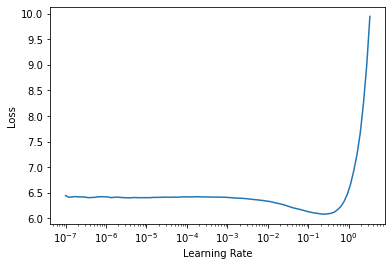

In [ ]:
learn.lr_find()

In [ ]:
lr = 3e-2

In [ ]:
learn.fit_one_cycle(1, lr, moms=(0.8,0.7,0.8))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.308383,4.133787,0.294455,62.413818,02:09


In [ ]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(lr/100,lr), moms=(0.8,0.7,0.8))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.093540,3.962888,0.312961,52.609043,02:36
1,4.038190,3.909860,0.320970,49.891972,02:36
2,3.942776,3.818472,0.332707,45.534565,02:36
3,3.853526,3.746795,0.341737,42.385006,02:37
4,3.773258,3.680940,0.350292,39.683685,02:35
5,3.709620,3.618464,0.358547,37.280262,02:35


Save the fine-tuned model to `path` (default is `learn.model_dir`) with all required files (Model, Encoder, Vocab and SentencePiece-Model)

`path` and `vocab` will be used for training the classifier.

In [ ]:
path = learn.save_lm('tmp/test_lm')
vocab = learn.dls.vocab

## Train the Classifier

In [ ]:
df = pd.read_csv(data_path/'data_classification.csv')

In [ ]:
dblocks = DataBlock(blocks=(TextBlock.from_df('text', tok=tok, vocab=vocab), CategoryBlock),
                    get_x=ColReader('text'),
                    get_y=ColReader('label'), 
                    splitter=ColSplitter())
dls = dblocks.dataloaders(df, bs=128)

`text_classifier_from_lm` calls `text_classifier_learner` to create a learner **from the fine-tuned model** `path`.

In [ ]:
learn = text_classifier_from_lm(dls, path=path, metrics=[accuracy]).to_fp16()

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(4, 3e-2)